# Exploratory Data Analysis for Stock Price Forecasting

Project by: Jana Nikolovska <br>
Supervised by: Giacomo Frisoni, MSc <br><!--  -->
Prof. Gianluca Moro, PhD <br>

ALMA MATER STUDITORIUM - University of Bologna <br>
November 2025

---

This notebook explores historical data from the S&P 500 to understand how the market behaves before building forecasting models.  
The goal is to get familiar with the data, look for important patterns, and identify the characteristics that will guide how we design and train time series models later on.

## 📣Summary
In the notebook is covered:

* check whether price levels or daily returns are stable over time - in order to decide which variable to model  
* look into how much past information is useful for prediction by studying the time dependencies in the data  
* check for possible seasonal patterns, whether certain days or months tend to perform differently  
* analyze how market volatility changes over time to see if there are calm and turbulent periods that might affect predictability  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf

# Import our utility functions
from src.utils import load_dataset, adf_test, download_and_process_sp500_data

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. 🔍Data Loading and Initial Inspection

**_Dataset Description:_**  
The dataset used in this notebook consists of historical stock data from the S&P 500 index, retrieved using the [`yfinance`](https://pypi.org/project/yfinance/) library. The S&P 500 is a market-capitalization-weighted index of 500 of the largest publicly traded companies in the United States, representing a broad snapshot of the U.S. equity market.

Using `yfinance`, we are able to access time series data for individual tickers within the S&P 500, including daily **Open**, **High**, **Low**, **Close**, **Adj Close**, and **Volume** values. 

Each daily record includes:
- **Open**: The price of the stock at the start of the trading day.
- **High**: The highest price the stock reached during the trading day.
- **Low**: The lowest price the stock reached during the trading day.
- **Close**: The final price of the stock when the market closed for that day.
- **Volume**: The total number of shares traded during the day, providing insight into market activity and liquidity.

This dataset was introduced to me by the professor when I was first introduced to the topic of time series forecasting in the context of finance. I found it to be a well-structured and high-quality dataset that is well-suited for experimentation and comparison between different forecasting methods.

**📈 Historical Context (2001-2008):**  
This period includes two major market events that significantly impacted volatility:
- **Dot-com bubble crash (2001-2002)**: Technology stock collapse after the internet boom
- **2008 Financial Crisis**: Subprime mortgage crisis leading to the Great Recession

These events explain the high volatility and extreme price movements we'll observe in our analysis.

In [2]:
# Download and process S&P 500 data from Yahoo Finance
df = download_and_process_sp500_data(
    start_date="2001-01-01",
    end_date="2008-12-31", 
    output_path="data/sp500_dates.csv"
)

print("\nData successfully loaded in the notebook...\n")

print(f"Open - Price range: ${df['Open'].min():.2f} - ${df['Open'].max():.2f}")
print(f"Close - Price range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")

✅ Data successfully saved to: data/sp500_dates.csv
📊 Data shape: (2920, 5)
📅 Date range: 2001-01-02 00:00:00-05:00 to 2008-12-30 00:00:00-05:00
🔍 Missing values: 0

Data successfully loaded in the notebook...

Open - Price range: $755.84 - $1564.98
Close - Price range: $752.44 - $1565.15


## 2. 💹Price Trends and Patterns. Stationarity Analysis 

First we check for stationarity because according to time series analysis literature many forecasting models such as ARIMA or GARCH assume that the data is **stationary**.  <br><br>
📖 _A **stationary** time series is one where the main statistical properties — like the mean and variance — stay constant over time, meaning the process behaves similarly in the past and the future._

Here, I check stationarity for:
1. **Price levels** – the raw closing prices from the dataset  
2. **Returns** – the percentage change between t consecutive prices, which is commonly used in financial modeling because of it's stationary

Returns are calculated as:

$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

where `P_t` is the price at time `t`. 
This measures how much the price changes from one period to the next.

To test whether the price and return series are stationary the following tests are being used:
- visually inspecting **graphs** of the data for trends or varying spread  
- checking **rolling mean and standard deviation** to see if they remain stable.  
- appling the **Augmented Dickey-Fuller (ADF) test**, which statistically tests the null hypothesis that a series is non-stationary.

These steps will show whether the original prices or their returns are suitable for modeling.


### 2.1 Graph

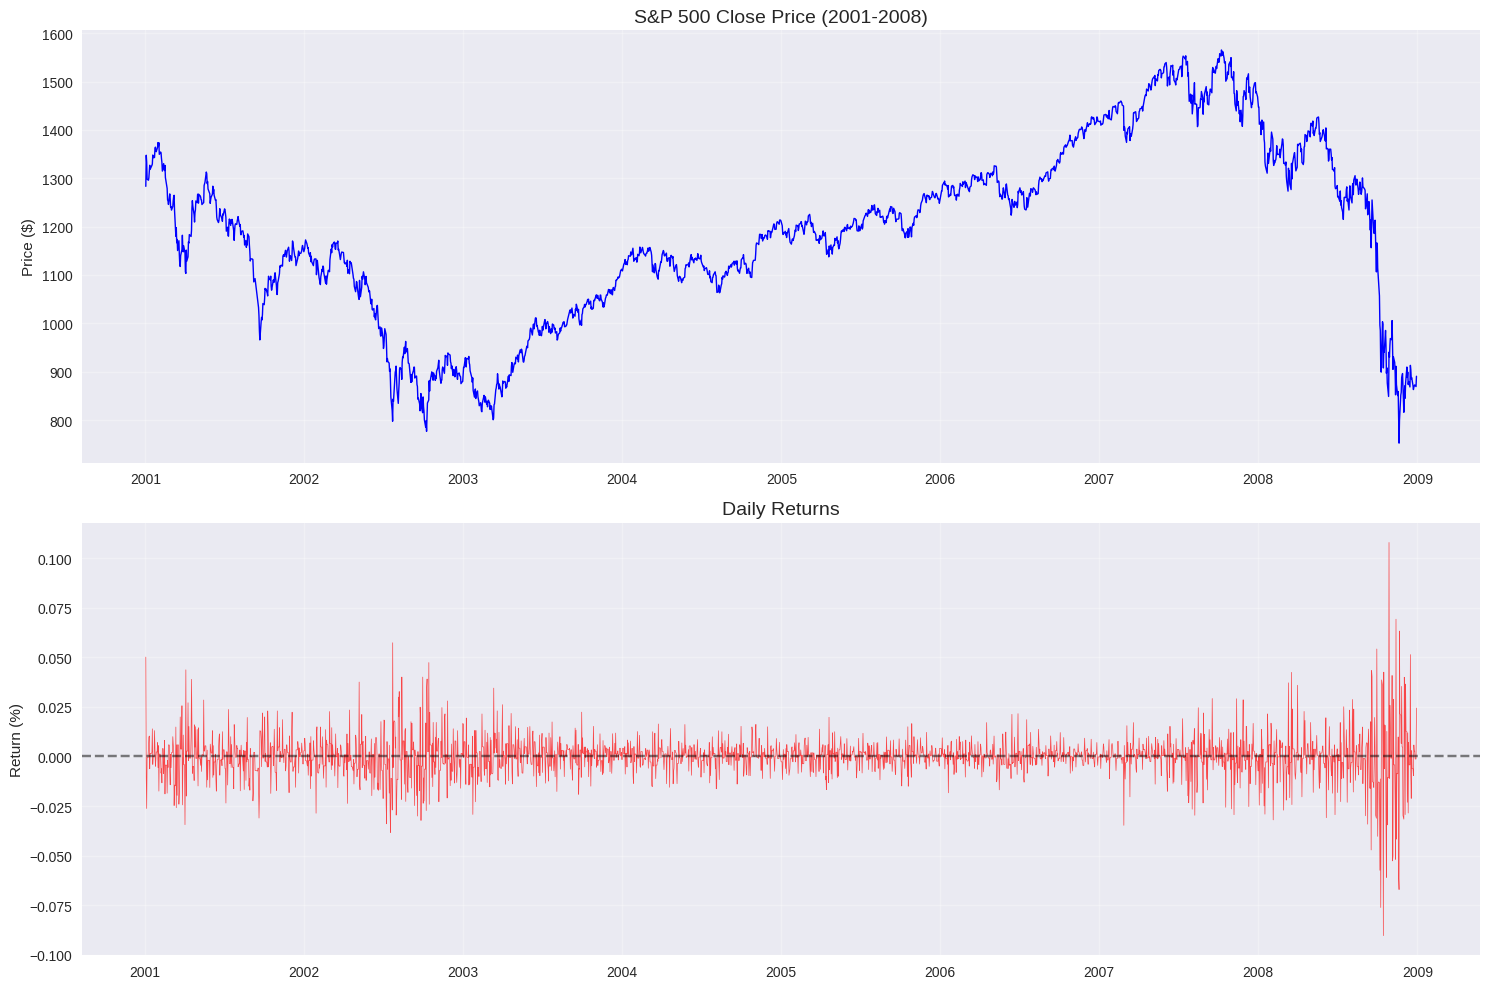

==========Results of Stationary tests:==========
Mean daily return: -0.0001 (-1.85% annualized)
Daily volatility: 0.0102 (16.15% annualized)
Skewness: 0.0809
Kurtosis: 13.9807
Min daily return: -9.03%
Max daily return: 10.79%


In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Raw price series
ax1.plot(df.index, df['Close'], linewidth=1, color='blue')
ax1.set_title('S&P 500 Close Price (2001-2008)', fontsize=14)
ax1.set_ylabel('Price ($)')
ax1.grid(True, alpha=0.3)

# Daily returns
returns = df['Close'].pct_change().dropna()
ax2.plot(returns.index, returns, linewidth=0.5, alpha=0.7, color='red')
ax2.set_title('Daily Returns', fontsize=14)
ax2.set_ylabel('Return (%)')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate key statistics
print("==========Results of Stationary tests:==========")
print(f"Mean daily return: {returns.mean():.4f} ({returns.mean()*252:.2%} annualized)")
print(f"Daily volatility: {returns.std():.4f} ({returns.std()*np.sqrt(252):.2%} annualized)")
print(f"Skewness: {returns.skew():.4f}")
print(f"Kurtosis: {returns.kurtosis():.4f}")
print(f"Min daily return: {returns.min():.2%}")
print(f"Max daily return: {returns.max():.2%}")

📖**Daily volatility**: This is the standard deviation of daily returns, which measures how much prices fluctuate day to day (how much percentage from the average) <br>
📖**Skewness**: measures the asymmetry of the return distribution (positive = more positive moves than negative ones <br>
-- Our value is around 0, which means symmery<br>
📖**Kurtosis**: how often extreme events happen <br>
-- For normal disctibution, the `Kurtosis value = 3`, in our case `~14` suggests frequent big shifts of value <br>

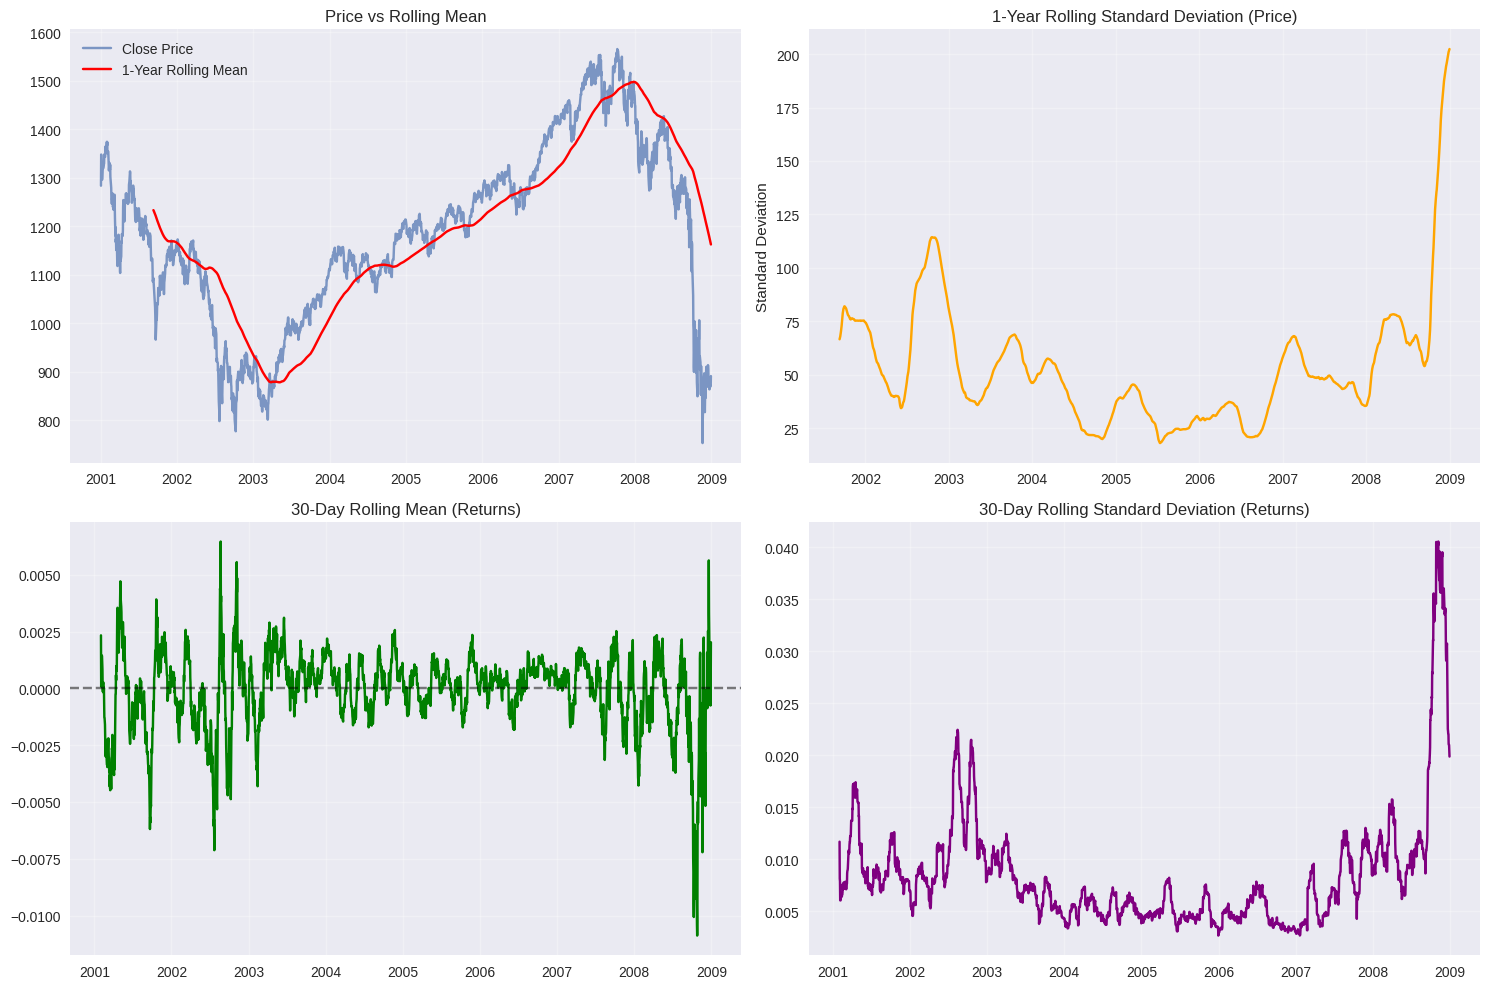

Rolling Statistics Analysis:
Price rolling mean stability: CV = 0.0260
Returns rolling mean near zero: Mean = -0.000094
Returns volatility changes over time: CV = 0.6831


In [4]:
# Rolling statistics to check stability over time
window = 252  # 1 year rolling window
rolling_mean = df['Close'].rolling(window=window).mean()
rolling_std = df['Close'].rolling(window=window).std()

returns_rolling_mean = returns.rolling(window=30).mean()
returns_rolling_std = returns.rolling(window=30).std()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Price rolling statistics
ax1.plot(df.index, df['Close'], label='Close Price', alpha=0.7)
ax1.plot(rolling_mean.index, rolling_mean, label='1-Year Rolling Mean', color='red')
ax1.set_title('Price vs Rolling Mean')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(rolling_std.index, rolling_std, color='orange')
ax2.set_title('1-Year Rolling Standard Deviation (Price)')
ax2.set_ylabel('Standard Deviation')
ax2.grid(True, alpha=0.3)

# Returns rolling statistics
ax3.plot(returns_rolling_mean.index, returns_rolling_mean, color='green')
ax3.set_title('30-Day Rolling Mean (Returns)')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.grid(True, alpha=0.3)

ax4.plot(returns_rolling_std.index, returns_rolling_std, color='purple')
ax4.set_title('30-Day Rolling Standard Deviation (Returns)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Rolling Statistics Analysis:")
print(f"Price rolling mean stability: CV = {(rolling_std/rolling_mean).std():.4f}")
print(f"Returns rolling mean near zero: Mean = {returns_rolling_mean.mean():.6f}")
print(f"Returns volatility changes over time: CV = {(returns_rolling_std/returns_rolling_std.mean()).std():.4f}")

📈 **Price rolling mean stability (CV = 0.026):**  
Small variation → price levels change gradually, trend is smooth and stable.

💹 **Returns rolling mean near zero (Mean = -0.000094):**  
No consistent upward/downward bias → returns fluctuate around zero → stationary and suitable for modeling.

⚡ **Returns volatility changes over time (CV = 0.6831):**  
Large variation → market risk shifts between calm and turbulent periods → clear volatility clustering.



📌 **Conclusion:**  
**Returns** are **stationary** and have **stable statistical properties**, unlike the raw **Closing values** which makes them much more suitable for time series forecasting.<br>
**However**, the distribution of returns isn’t normal = there are occasional huge jumps or drops which proves that the market is risky and unpredictable which still is a difficult task to model it

### 2.2. Augmented Dickey-Fuller (ADF)

In [5]:
print("=== STATIONARITY TESTS ===")
print("\n1. Price Levels:")
adf_test(df['Close'], 'Close Price')

print("\n2. First Difference (Returns):")
returns = df['Close'].pct_change().dropna()
adf_test(returns, 'Daily Returns')

=== STATIONARITY TESTS ===

1. Price Levels:

ADF Test on Close Price
ADF Statistic : -1.4746824698639978
p-value : 0.5459963254541066
# Lags Used : 28
Number of Observations Used : 2891
=> Series is NOT stationary

2. First Difference (Returns):

ADF Test on Daily Returns
ADF Statistic : -9.8727569384014
p-value : 3.954735161975448e-17
# Lags Used : 28
Number of Observations Used : 2890
=> Series is stationary


- The **Close Price** series has a high p-value (> 0.05), meaning it’s *non-stationary* — it trends over time.  
- The **Daily Returns** series has a very low p-value (< 0.05), meaning it’s *stationary* — its statistical properties remain stable.  

📌 **Conclusion:**  
We should **model returns instead of raw prices**, since stationary data allows for more reliable forecasting.

## 3. 🔁 Autocorrelation Analysis (ACF & PACF)

In this section of the notebook we include autocorrelation analysis tests to help understand **how much past information (lags)** is useful for predicting future returns (the **number of previous days** (lags) to include the predicting model) 

- 📖**ACF (Autocorrelation Function):** Measures how current returns relate to all past returns. It shows overall dependence.  
- 📖**PACF (Partial Autocorrelation Function):** Measures the direct correlation between current returns and specific past lags after removing the influence of shorter lags.

How to interpret the tests:
- If most values stay **within the 95% confidence limits**, it means **no significant autocorrelation** — the series behaves like **white noise** (random).  
- If there are **spikes outside the limits**, those lags might contain useful predictive information.


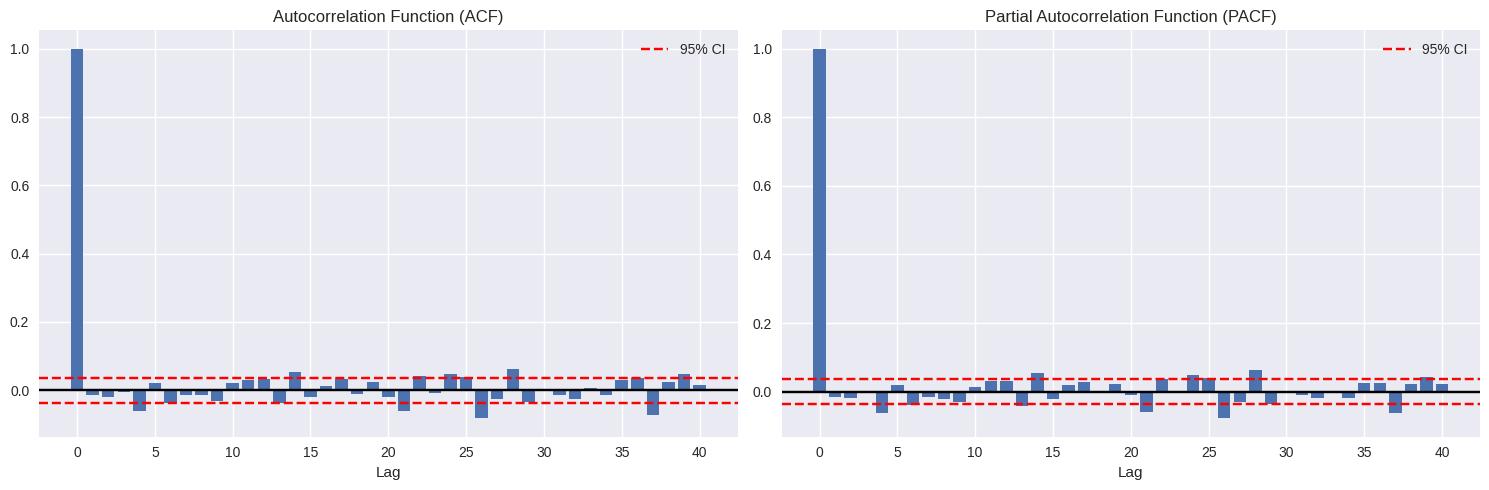

Significant lags (first 20): ACF=4, PACF=4
Insight: Use 4 days of history for prediction models


In [6]:
# ACF/PACF for returns to determine optimal lag structure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ACF
acf_vals = acf(returns, nlags=40)
ax1.bar(range(41), acf_vals)
ax1.axhline(y=0, color='black')
ax1.axhline(y=1.96/np.sqrt(len(returns)), color='red', linestyle='--', label='95% CI')
ax1.axhline(y=-1.96/np.sqrt(len(returns)), color='red', linestyle='--')
ax1.set_title('Autocorrelation Function (ACF)')
ax1.set_xlabel('Lag')
ax1.legend()

# PACF
pacf_vals = pacf(returns, nlags=40)
ax2.bar(range(41), pacf_vals)
ax2.axhline(y=0, color='black')
ax2.axhline(y=1.96/np.sqrt(len(returns)), color='red', linestyle='--', label='95% CI')
ax2.axhline(y=-1.96/np.sqrt(len(returns)), color='red', linestyle='--')
ax2.set_title('Partial Autocorrelation Function (PACF)')
ax2.set_xlabel('Lag')
ax2.legend()

plt.tight_layout()
plt.show()

# Count significant lags
threshold = 1.96/np.sqrt(len(returns))
significant_acf = np.sum(np.abs(acf_vals[1:21]) > threshold)
significant_pacf = np.sum(np.abs(pacf_vals[1:21]) > threshold)

print(f"Significant lags (first 20): ACF={significant_acf}, PACF={significant_pacf}")
print(f"Insight: Use {max(3, significant_pacf)} days of history for prediction models")

💡 **Interpretation of Results**
* Most bars lie within the red dashed lines, indicating weak autocorrelation.
* A few small spikes appear, but they don’t show any consistent or meaningful patter
    
📌 **Conclusion:** <br>
Returns are largely random, supporting the idea that past returns have little predictive power for future returns.

## 3. ⚡Volatility analysis of the Returns

📖 **Volatility** measures **how much Return values fluctuate** over time — it’s a way to measure market **risk or uncertainty**.  
Higher volatility means prices move a lot (more unpredictable), while low volatility means prices are stable. Mathematically, volatility is the **standard deviation of returns**.  

The purpose of this section is, since we already saw that there is a lot of unpredicability or the **Return** time series we want to see if we can: 
* identify **calm vs. turbulent periods**  
* check if **volatility clustering** exists 
* understand how changing volatility might affect prediction models.

To do so we use a calculation of **rolling (30-day) volatility** to see how market risk evolves over time and detect shifts between low- and high-volatility regimes.


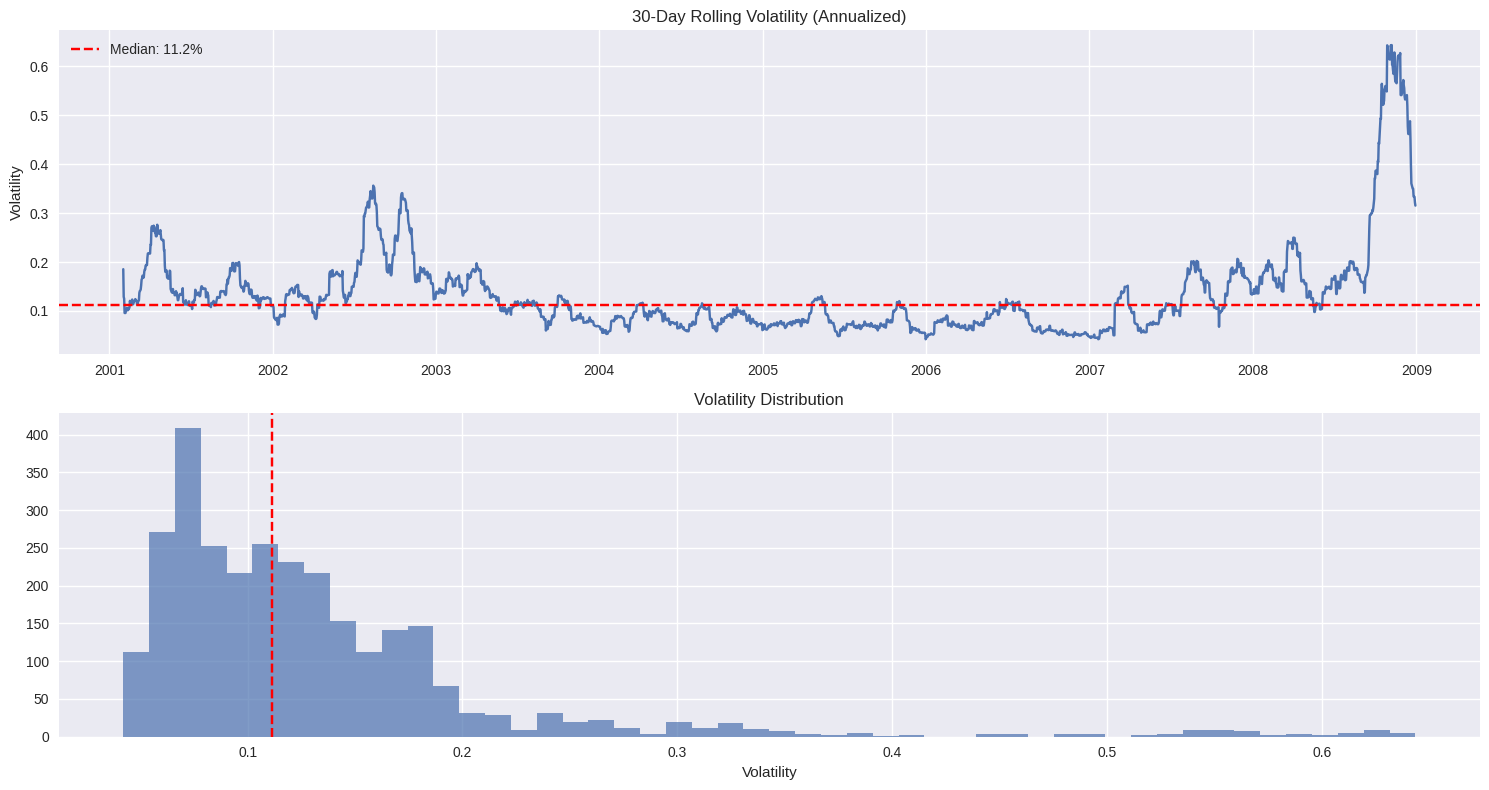

High volatility periods (>90th percentile): 289 days
📌 Insight: Volatility clustering present - models need to handle regime changes


In [7]:
# Rolling volatility to identify regime changes
rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)  # 30-day annualized volatility

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Volatility over time
ax1.plot(rolling_vol.index, rolling_vol)
ax1.set_title('30-Day Rolling Volatility (Annualized)')
ax1.set_ylabel('Volatility')
ax1.axhline(y=rolling_vol.median(), color='red', linestyle='--', label=f'Median: {rolling_vol.median():.1%}')
ax1.legend()

# Volatility distribution
ax2.hist(rolling_vol.dropna(), bins=50, alpha=0.7)
ax2.set_title('Volatility Distribution')
ax2.set_xlabel('Volatility')
ax2.axvline(x=rolling_vol.median(), color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Identify high volatility periods
high_vol_threshold = rolling_vol.quantile(0.9)
high_vol_periods = rolling_vol[rolling_vol > high_vol_threshold]
print(f"High volatility periods (>90th percentile): {len(high_vol_periods)} days")
print(f"📌 Insight: Volatility clustering present - models need to handle regime changes")

**Volatility clustering** means that large price movements (up or down) tend to happen close together in time — and same for small movements.
Periods of high volatility are followed by high volatility, and calm periods are followed by calm periods.
So instead of randomness, volatility comes in waves.

We expect simple models (like ARIMA or linear regression) that assume constant variance when modeling for example the Return value to struggle when volatility changes.

## 5. 🕒 Seasonality Analysis (Day & Month Effects)

In this section we search for **seasonal patterns**, whether certain **days of the week** or **months of the year** values differ from the others (find maybe a "Monday effect" or "January effect"). To do so we use an **ANOVA test** on values grouped by weekday and month. This way we can find **useful** patterns **or** just confirm whether the market follows a **random walk** pattern

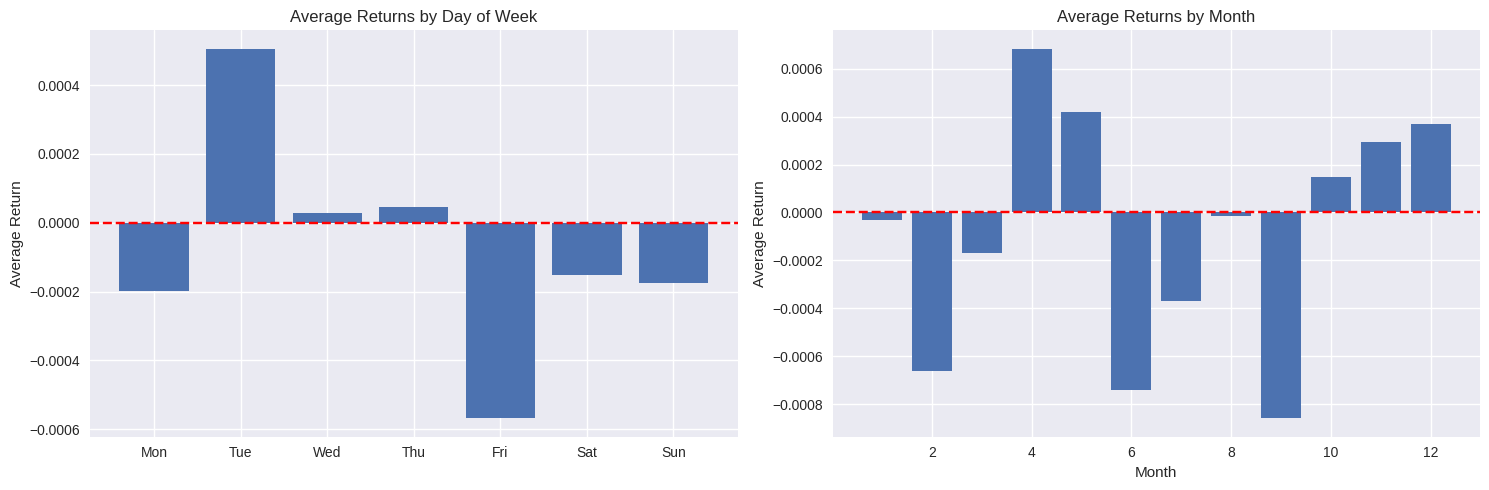

Seasonality test results (ANOVA p-values):
  Day-of-week effect: p = 0.8614
  Month-of-year effect: p = 0.8544

Statistical significance at α = 0.05:
  Weekday effect: Not significant
  Monthly effect: Not significant


In [8]:
# Seasonality analysis
returns_df = returns.to_frame('returns')
returns_df['weekday'] = returns_df.index.dayofweek
returns_df['month'] = returns_df.index.month

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Day of week effect
weekday_returns = returns_df.groupby('weekday')['returns'].mean()
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax1.bar(range(7), weekday_returns.values)
ax1.set_xticks(range(7))
ax1.set_xticklabels(weekday_names)
ax1.set_title('Average Returns by Day of Week')
ax1.set_ylabel('Average Return')
ax1.axhline(y=0, color='red', linestyle='--')

# Month effect
monthly_returns = returns_df.groupby('month')['returns'].mean()
ax2.bar(range(1, 13), monthly_returns.values)
ax2.set_title('Average Returns by Month')
ax2.set_xlabel('Month')
ax2.set_ylabel('Average Return')
ax2.axhline(y=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Statistical significance tests
from scipy import stats
weekday_pvalue = stats.f_oneway(*[returns_df[returns_df.weekday==i]['returns'] for i in range(7)]).pvalue
month_pvalue = stats.f_oneway(*[returns_df[returns_df.month==i]['returns'] for i in range(1, 13)]).pvalue

print(f"Seasonality test results (ANOVA p-values):")
print(f"  Day-of-week effect: p = {weekday_pvalue:.4f}")
print(f"  Month-of-year effect: p = {month_pvalue:.4f}")

significance_threshold = 0.05
weekday_significant = weekday_pvalue < significance_threshold
month_significant = month_pvalue < significance_threshold

print(f"\nStatistical significance at α = 0.05:")
print(f"  Weekday effect: {'Significant' if weekday_significant else 'Not significant'}")
print(f"  Monthly effect: {'Significant' if month_significant else 'Not significant'}")

- If the **p-value < 0.05**, returns depend on time → there’s a **seasonal effect**.  
- If the **p-value ≥ 0.05**, returns are random → **no strong seasonality**

From the statistical test results we can see that there are no calendar-based features that can be used for predicting

## 6. 🧠 Summary for Model Development

The analysis shows **no significant autocorrelation**, meaning past returns don’t strongly influence future ones — so we don’t need many lag features. 

There are **no clear seasonality patterns** to use as predictive features.  

We also observed **high volatility and volatility clustering**, suggesting it may be more effective to **model volatility itself** rather than just returns.  

However, for a **baseline**, we’ll start with simple models like **Linear Regression** and **ARIMA** applied to the return values, keeping in mind the insights about changing volatility.  

Overall, the data looks **highly unpredictable**, making this a challenging forecasting task — but it will be interesting to see **how LLM-based models handle this problem** compared to traditional approaches.


## 7. 💾 Data Export for Modeling

Create a **processed returns data** file for use in the forecasting models, since returns are stationary and more suitable for prediction than raw prices.

In [11]:
# Prepare modeling dataset with returns and additional features
modeling_data = pd.DataFrame({
    'date': returns.index,
    'returns': returns.values,
    'price': df['Close'].loc[returns.index], 
    'volume': df['Volume'].loc[returns.index], 
    'rolling_volatility': returns.rolling(window=30).std() * np.sqrt(252),  
    'returns_lag1': returns.shift(1),  # Previous day return
    'returns_lag2': returns.shift(2),  # 2-day lag
    'returns_lag3': returns.shift(3),  # 3-day lag
})

modeling_data = modeling_data.dropna()

modeling_data.set_index('date', inplace=True)

output_path = 'data/sp500_returns_modeling.csv'
modeling_data.to_csv(output_path)

print(f"✅ Modeling dataset saved to: {output_path}")
print(f"📊 Dataset shape: {modeling_data.shape}")
print(f"📅 Date range: {modeling_data.index.min().date()} to {modeling_data.index.max().date()}")
print(f"\n📋 Features included:")
for col in modeling_data.columns:
    print(f"  • {col}: {modeling_data[col].dtype}")

# Display first few rows
print(f"\n🔍 Sample data:")
print(modeling_data.head())

✅ Modeling dataset saved to: data/sp500_returns_modeling.csv
📊 Dataset shape: (2890, 7)
📅 Date range: 2001-02-01 to 2008-12-30

📋 Features included:
  • returns: float64
  • price: float64
  • volume: float64
  • rolling_volatility: float64
  • returns_lag1: float64
  • returns_lag2: float64
  • returns_lag3: float64

🔍 Sample data:
                            returns        price        volume  \
date                                                             
2001-02-01 00:00:00-05:00  0.005461  1373.469971  1.118800e+09   
2001-02-02 00:00:00-05:00 -0.017474  1349.469971  1.048400e+09   
2001-02-03 00:00:00-05:00  0.001196  1351.083333  1.036600e+09   
2001-02-04 00:00:00-05:00  0.001194  1352.696696  1.024800e+09   
2001-02-05 00:00:00-05:00  0.001193  1354.310059  1.013000e+09   

                           rolling_volatility  returns_lag1  returns_lag2  \
date                                                                        
2001-02-01 00:00:00-05:00            0.185403   